# Contents
* [Introduction](#Introduction)
  * [FRILL](#FRILL)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Strata](#Strata)
* [Setup](#Setup)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Metaclassifier](#Metaclassifier)
* [Results](#Results)
  * [Classifier prediction correlations](#Classifier-prediction-correlations)
* [Discussion](#Discussion)

# Introduction

In this notebook, the positive vs. negaative binary classification scenario is considered with the development set of FRILL embeddings.

A test harness is prepared for several models that showed promise in some previous explorations and the results are visualized.

## FRILL

Here are two abstracts to introduce the FRILL embedding:

  [Towards Learning a Universal Non-Semantic Representation of Speech (2020)](#https://doi.org/10.21437/Interspeech.2020-1242)
> The ultimate goal of transfer learning is to reduce labeled data requirements by exploiting a pre-existing embedding model trained for different datasets or tasks. The visual and language communities have established benchmarks to compare embeddings, but the speech community has yet to do so. This paper proposes a benchmark for comparing speech representations on non-semantic tasks, and proposes a representation based on an unsupervised triplet-loss objective. The proposed representation outperforms other representations on the benchmark, and even exceeds state-of-the-art performance on a number of transfer learning tasks. The embedding is trained on a publicly available dataset, and it is tested on a variety of low-resource downstream tasks, including personalization tasks and medical domain. The benchmark, models, and evaluation code are publicly released.

  [FRILL: A Non-Semantic Speech Embedding for Mobile Devices (2021)](#https://arxiv.org/abs/2011.04609)
> Learned speech representations can drastically improve performance on tasks with limited labeled data. However, due to their size and complexity, learned representations have limited utility in mobile settings where run-time performance can be a significant bottleneck. In this work, we propose a class of lightweight non-semantic speech embedding models that run efficiently on mobile devices based on the recently proposed TRILL speech embedding. We combine novel architectural modifications with existing speed-up techniques to create embedding models that are fast enough to run in real-time on a mobile device and exhibit minimal performance degradation on a benchmark of non-semantic speech tasks. One such model (FRILL) is 32x faster on a Pixel 1 smartphone and 40% the size of TRILL, with an average decrease in accuracy of only 2%. To our knowledge, FRILL is the highest-quality non-semantic embedding designed for use on mobile devices. Furthermore, we demonstrate that these representations are useful for mobile health tasks such as non-speech human sounds detection and face-masked speech detection. Our models and code are publicly available.

FRILL is therefore a promising embedding since non-semantic aspects of speech signals is what distinguishes each class for this data. And it's fast!

Moreover, its output representation is a 2,048-element vector irrespective of input size. FRILL enables uniform handling of ragged sequences in an output format that is potentially more compact than spectrograms and MFCCs.

Furthermore, the FRILL representations are not time series, affording the full armamentarium of classifiers.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# typing
from typing import Dict, List

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from sklearn.metrics import balanced_accuracy_score, f1_score

# cross validator
from sklearn.model_selection import StratifiedGroupKFold

# sklearn classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# other boosting classifiers
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 6.62 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 114 ms


# Data loading
For this classification task, we need two sets of class labels: neutral/non-neutral and positive/negative.

In [5]:
keep_columns = [
    "id",
    "source",
    "speaker_id",
    "speaker_gender",
    "emo",
    "valence",
    "lang1",
    "length",
]

data = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather").set_index("id")
labels = pd.read_feather(
    f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
).set_index("id")

time: 576 ms


The next cell prepares the data for both classification sub-tasks.

In [6]:
# re-order 0: negative, 1: neutral, 2: positive to 0: negative, 1: positive, 2: neutral
print("before")
labels.valence.value_counts()
labels.eval("valence = ((valence.replace(1, 3) - 1) // 2) + 1", inplace=True)
print("after")
labels.valence.value_counts()

before


0    9706
2    4444
1    3553
Name: valence, dtype: int64

after


0    9706
1    4444
2    3553
Name: valence, dtype: int64

time: 28.1 ms


In [7]:
# uncomment lines to undersample data
# data = data.sample(frac=0.05, random_state=SEED).sort_index()
# labels = labels.loc[data.index, :]

assert all(data.index == labels.index)
_ = gc_collect()

time: 106 ms


In [8]:
# check indices for subsetting data for positive vs. negative
print("positive/negative labels:")
labels.loc[labels.valence != 2].valence.value_counts()
print("neutral/non-neutral labels:")
(labels.valence // 2).value_counts()  # shortcut

positive/negative labels:


0    9706
1    4444
Name: valence, dtype: int64

neutral/non-neutral labels:


0    14150
1     3553
Name: valence, dtype: int64

time: 7.15 ms


In [9]:
data.head(1)
data.info()
labels.head(1)
labels.info()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,-0.226529,-0.091773,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.06233


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 138.4 MB


,source,speaker_id,speaker_gender,emo,valence,lang1,length
id,,,,,,,
0,aesdd,aesdd.1,f,ang,0,ell,medium


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          17703 non-null  category
 1   speaker_id      17703 non-null  category
 2   speaker_gender  17703 non-null  category
 3   emo             17703 non-null  category
 4   valence         17703 non-null  int8    
 5   lang1           17703 non-null  category
 6   length          17703 non-null  category
dtypes: category(6), int8(1)
memory usage: 321.6 KB
time: 160 ms


# Strata

In this section, strata are set up for the train-test split.

In [10]:
n_splits = 3

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels[["source", "speaker_gender", "emo", "valence", "lang1", "length"]]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Pandas Apply: 100%|██████████| 17703/17703 [00:00<00:00, 76265.16it/s]

time: 286 ms


In [11]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_solos(
    strata_: pd.Series, print_me: str = "", n_splits: int = n_splits
) -> List[np.ndarray]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solos.append(solo := get_solo(i, strata_))
        print(f"only {i}:", len(solo))
    return solos


def process_strata(strata: pd.Series, n_splits: int = n_splits) -> pd.Series:
    """Corrects strata membership column according to n_splits=3"""

    only1, only2 = get_solos(strata, print_me="before")

    # replace, 2 + 1 = 3
    count = 0
    for stratum_pair in zip(only1, only2):
        strata.replace(stratum_pair, f"stratum_group_{count}", inplace=True)
        count += 1

    # one of these should print 0
    only1, only2 = get_solos(strata, print_me="after first-pass merge")

    if any((only1.size, only2.size)):
        # merge remaining strata with only 1 occurence into triplets (for n_splits=3)
        interval = len(only1) // n_splits
        for strata_to_merge in zip(
            *[only1[interval * i : interval * (i + 1)] for i in range(n_splits)]
        ):
            strata.replace(strata_to_merge, f"stratum_group_{count}", inplace=True)
            count += 1

        # one of these should print 0 and the other <=2
        only1, only2 = get_solos(strata, print_me="after second-pass merge")

        if any((only1.size, only2.size)):
            i = 0
            for only in (only1, only2):
                for remainder in only:
                    n = n_splits
                    strata_counts = strata.value_counts()
                    while (
                        len(_ := strata_counts.where(strata_counts == n).dropna()) == 0
                    ):
                        n += 1
                    strata.replace(
                        [_.dropna().sample(n=1, random_state=SEED + i).index[0]]
                        + [remainder],
                        f"stratum_group_{count}",
                        inplace=True,
                    )
                    count += 1
                    i += 1
            only1, only2 = get_solos(strata, print_me="after third-pass merge")


_ = gc_collect()

time: 109 ms


In [12]:
process_strata(strata)
strata.value_counts()

before
only 1: 28
only 2: 19
after first-pass merge
only 1: 9
only 2: 0
after second-pass merge
only 1: 0
only 2: 0


esdfsur0cmnmedium               984
esdfang0cmnmedium               982
esdfsad0cmnmedium               736
esdmhap1cmnmedium               689
esdfhap1cmnmedium               688
                               ... 
stratum_group_4                   3
EmoReact_V_1.0mfru0englong        3
EmoReact_V_1.0fsur0engmedium      3
stratum_group_20                  3
cafefang0fralong                  3
Length: 183, dtype: int64

time: 109 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of three-fold cross validation such that the results may be easily cast to a `pandas` dataframe.

In [13]:
METRICS = (
    "avg_cv_balanced_accuracy",
    "avg_cv_f1",
    "avg_cv_fit_time",
    "avg_cv_predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", *METRICS}}
RESULTS = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List], case: str, model_name: str, avg_scores: AvgScores
) -> None:
    "Appends a model's score and fit/predict times to the results dict."
    for attribute, value in {
        ("model_name", model_name),
        ("case", case),
        ("avg_cv_balanced_accuracy", avg_scores.avg_cv_balanced_accuracy),
        ("avg_cv_f1", avg_scores.avg_cv_f1),
        ("avg_cv_fit_time", avg_scores.avg_cv_fit_time),
        ("avg_cv_predict_time", avg_scores.avg_cv_predict_time),
    }:
        where[attribute].append(value)


ALL_CASES = {"negpos", "neutral", "ternary_hybrid"}

_ = gc_collect()

time: 132 ms


In [14]:
PREDICTIONS = {key: [] for key in {"model", "case", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", PREDICTIONS.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 112 ms


The cross-validation splits are pre-computed to save time in the main loops.

In [15]:
CV_info = namedtuple(
    "CV_info", "X_train X_test y_train y_test X_score_negpos", defaults=[None] * 5
)
assert all(data.index == strata.index)
assert all(strata.index == labels.index)
prepared_splits = [
    *StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(
        X=data, y=strata, groups=labels.speaker_id
    )
]


def get_splits(case: str) -> List[CV_info]:
    """Prepares the three-fold cross-validation splits for positive vs. negative or neutral vs. non-neutral classification."""
    splits = []
    for train_idx, test_idx in prepared_splits:
        X_train = data.iloc[train_idx]
        X_test = data.iloc[test_idx]
        y_train = labels.valence.iloc[train_idx]
        y_test = labels.valence.iloc[test_idx]

        if case == "negpos":
            # filter training data for negpos
            y_train = y_train.loc[y_train != 2]
            X_train = X_train.loc[y_train.index, :]
            # filter test labels for negpos
            y_test = y_test.loc[y_test != 2]
            # X for binary scoring (full X for metaclassifier)
            X_score_negpos = X_test.loc[y_test.index, :].reset_index(drop=True)
        elif case == "neutral":
            y_train = y_train // 2
            y_test = y_test // 2
            X_score_negpos = None
        else:  # case == "ternary_hybrid"
            splits.append(CV_info(y_test=y_test.reset_index(drop=True)))
            continue

        # reset indices
        splits.append(
            CV_info(
                X_train=X_train.reset_index(drop=True),
                y_train=y_train.reset_index(drop=True),
                X_test=X_test.reset_index(drop=True),
                y_test=y_test.reset_index(drop=True),
                X_score_negpos=X_score_negpos,
            )
        )
    return splits


data_chooser: Dict[str, List[CV_info]] = {case: get_splits(case) for case in ALL_CASES}

_ = gc_collect()

time: 1.71 s


# Models

Thanks to FRILL, we may now use the gamut of classifiers provided by `sklearn`. Boosting methods outside of `sklearn` include `LightGBM` and `XGBoost`.

For the most part, the default settings of each classifier are used. Where possible, the seed is set and all available cores are used. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

In [16]:
models = {
    "AdaBoostClassifier": lambda: AdaBoostClassifier(random_state=SEED),
    "LogisticRegression": lambda: LogisticRegression(random_state=SEED, n_jobs=-1),
    "MLPClassifier": lambda: MLPClassifier(random_state=SEED),
    "RandomForestClassifier": lambda: RandomForestClassifier(
        n_jobs=-1, random_state=SEED
    ),
    "RidgeClassifier": lambda: RidgeClassifier(random_state=SEED),
    "SGDClassifier": lambda: SGDClassifier(n_jobs=-1, random_state=SEED),
    "SVC": lambda: SVC(random_state=SEED),
    "LGBMClassifier": lambda: LGBMClassifier(
        boosting_type="rf",
        random_state=SEED,
        n_jobs=-1,
        subsample=0.75,
        subsample_freq=1,
    ),
    "XGBClassifier": lambda: XGBClassifier(
        eval_metric="mlogloss", seed=SEED, use_label_encoder=False
    ),
    "DummyClassifier": lambda: DummyClassifier(random_state=SEED),
}
_ = gc_collect()

time: 113 ms


# Test harness

This section defines functions for evaluating models.

In [17]:
def evaluate_binary_model(
    model_base: str, case: str, track_fold_time: bool = False
) -> AvgScores:
    """Evaluate a binary classification model with three-fold stratified grouped cross validation."""

    fit_times, predict_times, balanced_accuracy, f1 = [], [], [], []
    selected_data: List[CV_info] = data_chooser[case]
    for fold_num in range(n_splits):
        if track_fold_time:
            fold_begin = time()

        # obtain prepared folds
        fold_data: CV_info = selected_data[fold_num]

        # define train
        X_train = fold_data.X_train
        y_train = fold_data.y_train

        # define test
        X_test = fold_data.X_test
        y_test = fold_data.y_test

        # initialize binary model
        model = models[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        fit_times.append(end - begin)

        # predict
        begin = time()
        predicted_store = model.predict(X_test)
        end = time()
        if case == "neutral":
            predicted_score = predicted_store
        else:  # case == "negpos"
            # filtered prediction set for binary
            posneg_X_test = fold_data.X_score_negpos
            # re-time
            begin = time()
            predicted_score = model.predict(posneg_X_test)
            end = time()
            del posneg_X_test

        # store prediction results
        predict_times.append(end - begin)
        store_prediction(
            where=PREDICTIONS,
            prediction=Prediction(
                model=model_base, case=case, fold=fold_num, y_pred=predicted_store
            ),
        )

        # score
        score_params = {"y_true": y_test, "y_pred": predicted_score}
        balanced_accuracy.append(balanced_accuracy_score(**score_params))
        f1.append(f1_score(**score_params, average="weighted"))

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )

        # free some memory
        del begin
        del end
        del model
        del predicted_score
        del predicted_store
        del score_params
        del X_test
        del X_train
        del y_test
        del y_train
        _ = gc_collect()

    return AvgScores(
        *[np.mean(_) for _ in (balanced_accuracy, f1, fit_times, predict_times)]
    )


_ = gc_collect()

time: 152 ms


The underlying binary cases are evaluated while recording their predictions.

In [18]:
for case in {"negpos", "neutral"}:
    for model in tqdm(models):
        store_result(
            where=RESULTS,
            case=case,
            model_name=model,
            avg_scores=evaluate_binary_model(model, case, track_fold_time=True),
        )
        print(f"stored {model} for binary {case} classification")
        _ = gc_collect()

  0%|          | 0/10 [00:00<?, ?it/s]

AdaBoostClassifier fold 1 completed in 84.83 s
AdaBoostClassifier fold 2 completed in 138.50 s
AdaBoostClassifier fold 3 completed in 136.29 s
stored AdaBoostClassifier for binary negpos classification
LogisticRegression fold 1 completed in 1.99 s
LogisticRegression fold 2 completed in 2.87 s
LogisticRegression fold 3 completed in 2.51 s
stored LogisticRegression for binary negpos classification
MLPClassifier fold 1 completed in 36.51 s
MLPClassifier fold 2 completed in 45.28 s
MLPClassifier fold 3 completed in 42.04 s
stored MLPClassifier for binary negpos classification
RandomForestClassifier fold 1 completed in 2.73 s
RandomForestClassifier fold 2 completed in 3.89 s
RandomForestClassifier fold 3 completed in 3.61 s
stored RandomForestClassifier for binary negpos classification
RidgeClassifier fold 1 completed in 0.71 s
RidgeClassifier fold 2 completed in 0.97 s
RidgeClassifier fold 3 completed in 0.94 s
stored RidgeClassifier for binary negpos classification
SGDClassifier fold 1 co

  0%|          | 0/10 [00:00<?, ?it/s]

AdaBoostClassifier fold 1 completed in 114.54 s
AdaBoostClassifier fold 2 completed in 175.52 s
AdaBoostClassifier fold 3 completed in 155.71 s
stored AdaBoostClassifier for binary neutral classification
LogisticRegression fold 1 completed in 2.19 s
LogisticRegression fold 2 completed in 3.09 s
LogisticRegression fold 3 completed in 3.07 s
stored LogisticRegression for binary neutral classification
MLPClassifier fold 1 completed in 34.95 s
MLPClassifier fold 2 completed in 45.41 s
MLPClassifier fold 3 completed in 45.03 s
stored MLPClassifier for binary neutral classification
RandomForestClassifier fold 1 completed in 2.51 s
RandomForestClassifier fold 2 completed in 3.72 s
RandomForestClassifier fold 3 completed in 3.83 s
stored RandomForestClassifier for binary neutral classification
RidgeClassifier fold 1 completed in 0.83 s
RidgeClassifier fold 2 completed in 1.07 s
RidgeClassifier fold 3 completed in 0.98 s
stored RidgeClassifier for binary neutral classification
SGDClassifier fol

Let's peek at the binary results.

In [19]:
results_df = (
    pd.DataFrame(RESULTS).sort_values(by=["case", "model_name"]).reset_index(drop=True)
)
results_df

,avg_cv_balanced_accuracy,avg_cv_f1,avg_cv_fit_time,case,avg_cv_predict_time,model_name
0,0.566704,0.628097,119.357221,negpos,0.244681,AdaBoostClassifier
1,0.500000,0.527852,0.000999,negpos,0.000333,DummyClassifier
2,0.516826,0.561618,13.168620,negpos,0.183228,LGBMClassifier
3,0.612583,0.674095,2.381367,negpos,0.029696,LogisticRegression
4,0.634801,0.695667,41.171439,negpos,0.039393,MLPClassifier
5,0.507463,0.541235,3.104830,negpos,0.140210,RandomForestClassifier
6,0.617620,0.677212,0.804708,negpos,0.031887,RidgeClassifier
7,0.615902,0.666493,2.952214,negpos,0.141151,SGDClassifier
8,0.604179,0.672081,2.938194,negpos,1.187237,SVC
9,0.573157,0.640647,104.866848,negpos,0.092303,XGBClassifier


time: 25 ms


# Metaclassifier

After the binary classifiers are evaluated, the metaclassifiers are evaluated based on the binary predictions. The metaclassifiers' fit and score times are estimated by summing the fit and score times of the base estimators.

In [20]:
# set up the "metaclassifier"
TERNARY_RESULTS: Dict[str, List] = make_results()
ternary_hybrid_ytest: List[pd.Series] = [
    data_chooser["ternary_hybrid"][fold].y_test for fold in range(n_splits)
]  # list indexed by fold

# convenience function
get_time = lambda case, model_name, metric: results_df.query(
    f"case == '{case}' & model_name == '{model_name}'"
)[metric].values[0]

predictions_df = pd.DataFrame(PREDICTIONS)

for neutral_model in tqdm(models.keys()):
    for negpos_model in models.keys():
        balanced_accuracy, f1 = [], []
        model_combo = f"{neutral_model}+{negpos_model}"
        for fold_num in range(n_splits):

            # ensemble
            fold_df = predictions_df.query(f"fold == {fold_num}")
            neutral_condition = f"case == 'neutral' & model == '{neutral_model}'"
            negpos_condition = f"case == 'negpos' & model == '{negpos_model}'"
            query_fold = lambda criteria: fold_df.query(criteria).y_pred.item()
            df = pd.DataFrame(
                {
                    "neutral_prediction": query_fold(neutral_condition),
                    "negpos_prediction": query_fold(negpos_condition),
                }
            )
            del fold_df
            del negpos_condition
            del neutral_condition
            del query_fold

            # "predict"
            df["hybrid_prediction"] = df.neutral_prediction.replace(1, 2)
            df.loc[df.hybrid_prediction == 0, "hybrid_prediction"] = df.loc[
                df.hybrid_prediction == 0, "negpos_prediction"
            ]  # 0: negative, 1: positive, 2: neutral
            y_pred = df.hybrid_prediction
            del df

            # record y_pred
            store_prediction(
                where=PREDICTIONS,
                prediction=Prediction(
                    model=model_combo,
                    case="ternary_hybrid",
                    fold=fold_num,
                    y_pred=y_pred,
                ),
            )

            # score
            score_params = {
                "y_true": ternary_hybrid_ytest[fold_num],
                "y_pred": y_pred,
            }
            balanced_accuracy.append(balanced_accuracy_score(**score_params))
            f1.append(f1_score(**score_params, average="weighted"))
            del score_params
            del y_pred

            _ = gc_collect()

        # convenience function
        sum_times = lambda time_metric: get_time(
            "neutral", neutral_model, time_metric
        ) + get_time("negpos", negpos_model, time_metric)

        store_result(
            where=TERNARY_RESULTS,
            case="ternary_hybrid",
            model_name=model_combo,
            avg_scores=AvgScores(
                np.mean(balanced_accuracy),
                np.mean(f1),
                sum_times("avg_cv_fit_time"),
                sum_times("avg_cv_predict_time"),
            ),
        )

        print(f"stored hybrid ternary classification results for {model_combo}")

        del balanced_accuracy
        del f1
        del model_combo
        _ = gc_collect()

# re-define predictions_df since PREDICTIONS has been modified
predictions_df = pd.DataFrame(PREDICTIONS)

  0%|          | 0/10 [00:00<?, ?it/s]

stored hybrid ternary classification results for AdaBoostClassifier+AdaBoostClassifier
stored hybrid ternary classification results for AdaBoostClassifier+LogisticRegression
stored hybrid ternary classification results for AdaBoostClassifier+MLPClassifier
stored hybrid ternary classification results for AdaBoostClassifier+RandomForestClassifier
stored hybrid ternary classification results for AdaBoostClassifier+RidgeClassifier
stored hybrid ternary classification results for AdaBoostClassifier+SGDClassifier
stored hybrid ternary classification results for AdaBoostClassifier+SVC
stored hybrid ternary classification results for AdaBoostClassifier+LGBMClassifier
stored hybrid ternary classification results for AdaBoostClassifier+XGBClassifier
stored hybrid ternary classification results for AdaBoostClassifier+DummyClassifier
stored hybrid ternary classification results for LogisticRegression+AdaBoostClassifier
stored hybrid ternary classification results for LogisticRegression+LogisticReg

Let's peek at the ternary results.

In [21]:
ternary_results_df = (
    pd.DataFrame(TERNARY_RESULTS).sort_values(by=["model_name"]).reset_index(drop=True)
)
ternary_results_df

,avg_cv_balanced_accuracy,avg_cv_f1,avg_cv_fit_time,case,avg_cv_predict_time,model_name
0,0.436877,0.502170,267.639229,ternary_hybrid,0.539469,AdaBoostClassifier+AdaBoostClassifier
1,0.394166,0.428693,148.283007,ternary_hybrid,0.295121,AdaBoostClassifier+DummyClassifier
2,0.404961,0.454575,161.450627,ternary_hybrid,0.478015,AdaBoostClassifier+LGBMClassifier
3,0.465633,0.532956,150.663374,ternary_hybrid,0.324484,AdaBoostClassifier+LogisticRegression
4,0.478697,0.547072,189.453447,ternary_hybrid,0.334181,AdaBoostClassifier+MLPClassifier
...,...,...,...,...,...,...
95,0.397770,0.439718,126.263660,ternary_hybrid,0.265514,XGBClassifier+RandomForestClassifier
96,0.470597,0.538457,123.963539,ternary_hybrid,0.157192,XGBClassifier+RidgeClassifier
97,0.469646,0.531343,126.111044,ternary_hybrid,0.266456,XGBClassifier+SGDClassifier
98,0.460630,0.535131,126.097025,ternary_hybrid,1.312542,XGBClassifier+SVC


time: 25 ms


# Results

In this section, we create several visualizations to display the results.

In [22]:
metric_names = {
    "avg_cv_balanced_accuracy": "balanced accuracy",
    "avg_cv_f1": "F1 score",
    "avg_cv_fit_time": "fit time",
    "avg_cv_predict_time": "predict time",
}


def plot_binary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    if time_metric:
        # When plotting fit/predict times, the dummy classifier is omitted since it is always the fastest.
        results_df = results_df.loc[results_df.model_name != "DummyClassifier"]
    results_df.model_name = results_df.model_name.str.replace("Classifier", "")
    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="case",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette=dict(
            zip(
                cases := np.unique(results_df.case),
                sns.color_palette(palette="colorblind", n_colors=len(cases)),
            )
        ),
        legend=False,  # reset legend
        alpha=0.8,
    )
    plt.legend(loc="upper center", frameon=False)  # reset legend
    if not time_metric:
        plt.ylim(0, 1)
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    plt.xlabel("")
    plt.ylabel("")
    plt.suptitle(f"{metric_names[metric]}{' (s)' if time_metric else ''}")
    plt.tight_layout()
    plt.show()


def plot_ternary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by ternary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    if time_metric:
        # When plotting fit/predict times, the dummy+dummy classifier is omitted since it is always the fastest.
        results_df = results_df.loc[
            results_df.model_name != "DummyClassifier+DummyClassifier"
        ]
    results_df.model_name = results_df.model_name.str.replace("Classifier", "")

    g = sns.catplot(
        x=metric,
        y="model_name",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.8,
    )
    plt.gca().tick_params(axis="x", labelbottom=True, labeltop=True)

    if not time_metric:
        plt.xlim(0, 1)
    g.fig.set_figwidth(10)
    g.fig.set_figheight(16)
    g.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))
    plt.xlabel("")
    plt.ylabel("")
    plt.suptitle(f"{metric_names[metric]}{' (s)' if time_metric else ''}")
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 126 ms


  0%|          | 0/4 [00:00<?, ?it/s]

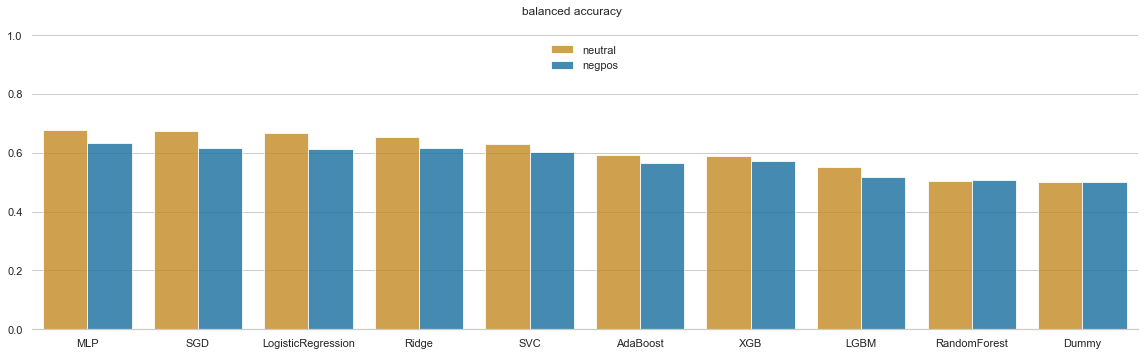

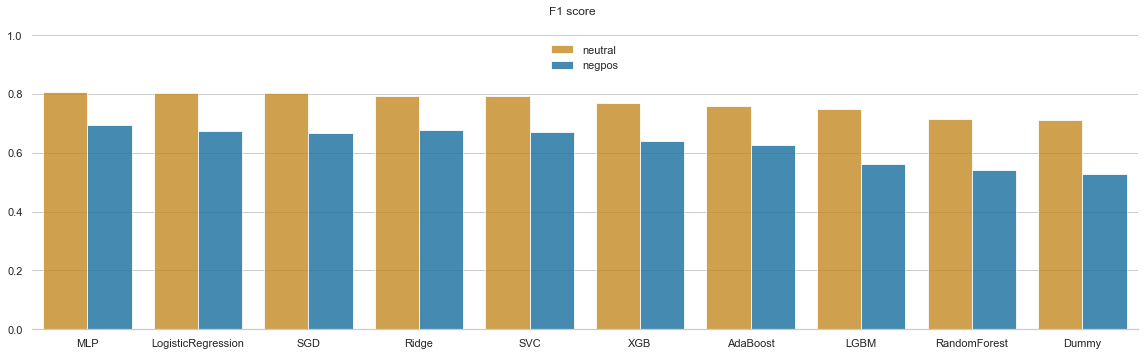

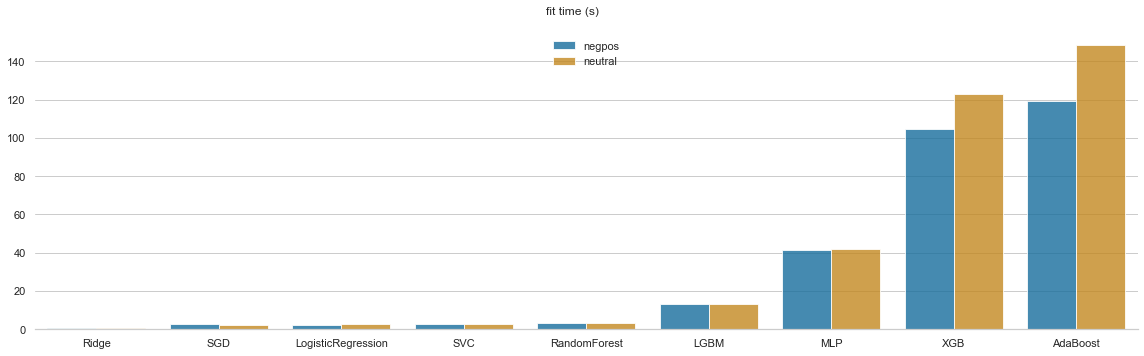

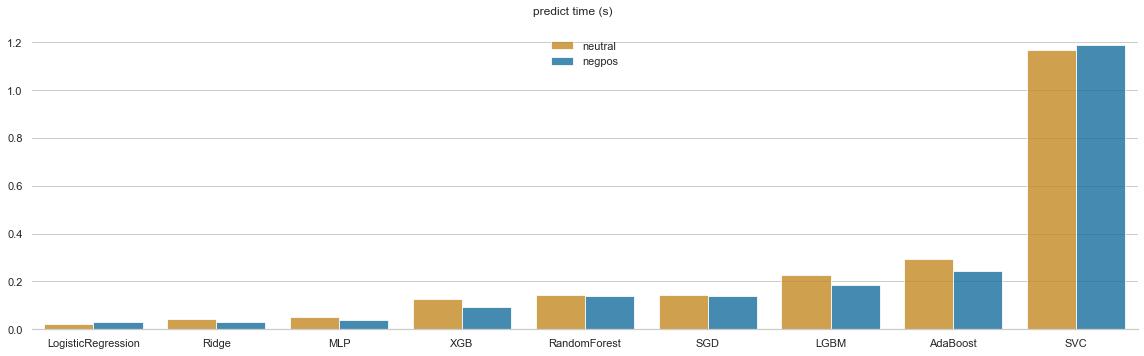

time: 1.68 s


In [23]:
for metric in tqdm(METRICS):
    plot_binary_metric(metric, results_df)

  0%|          | 0/4 [00:00<?, ?it/s]

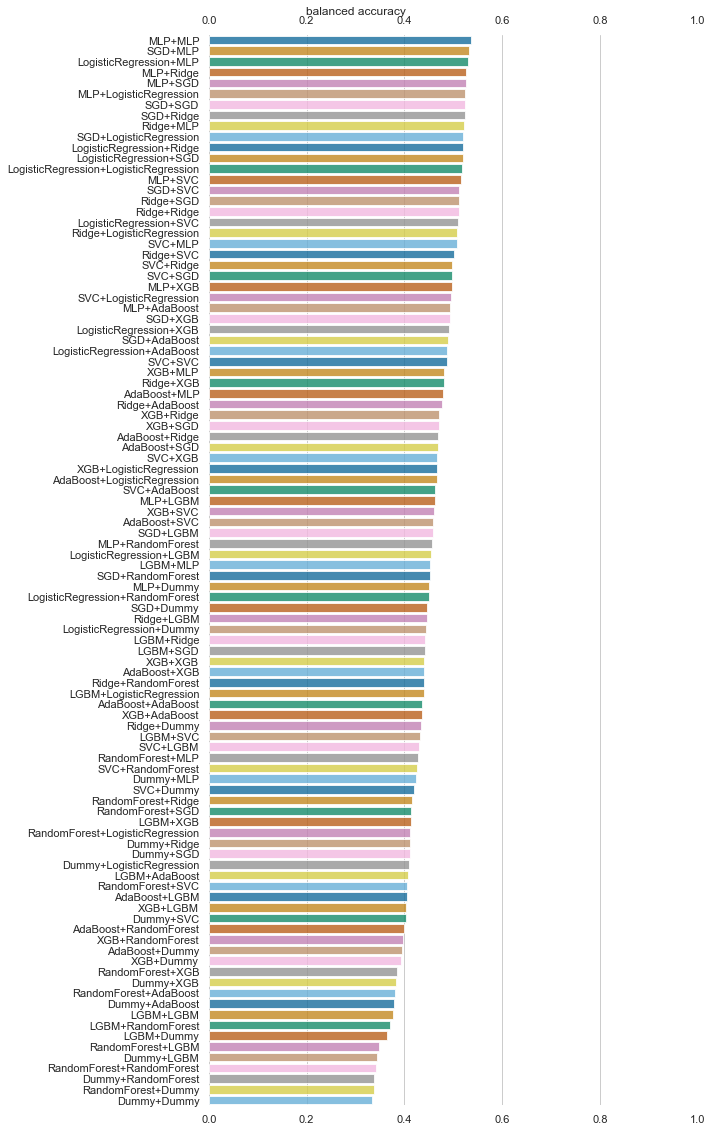

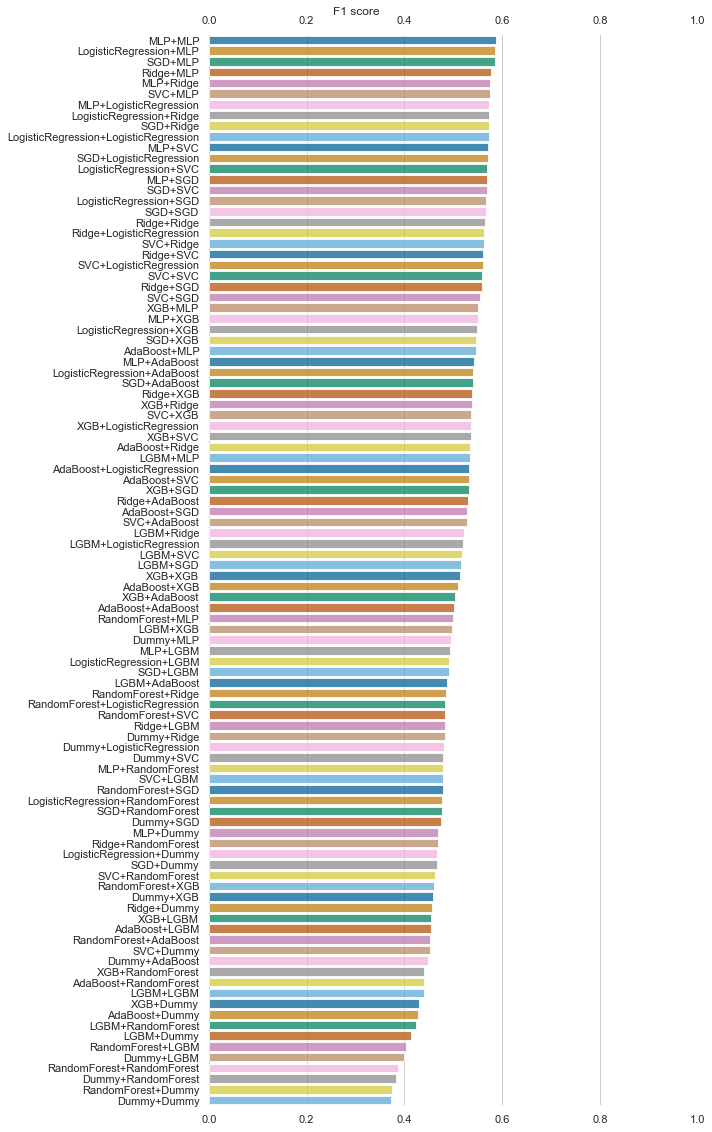

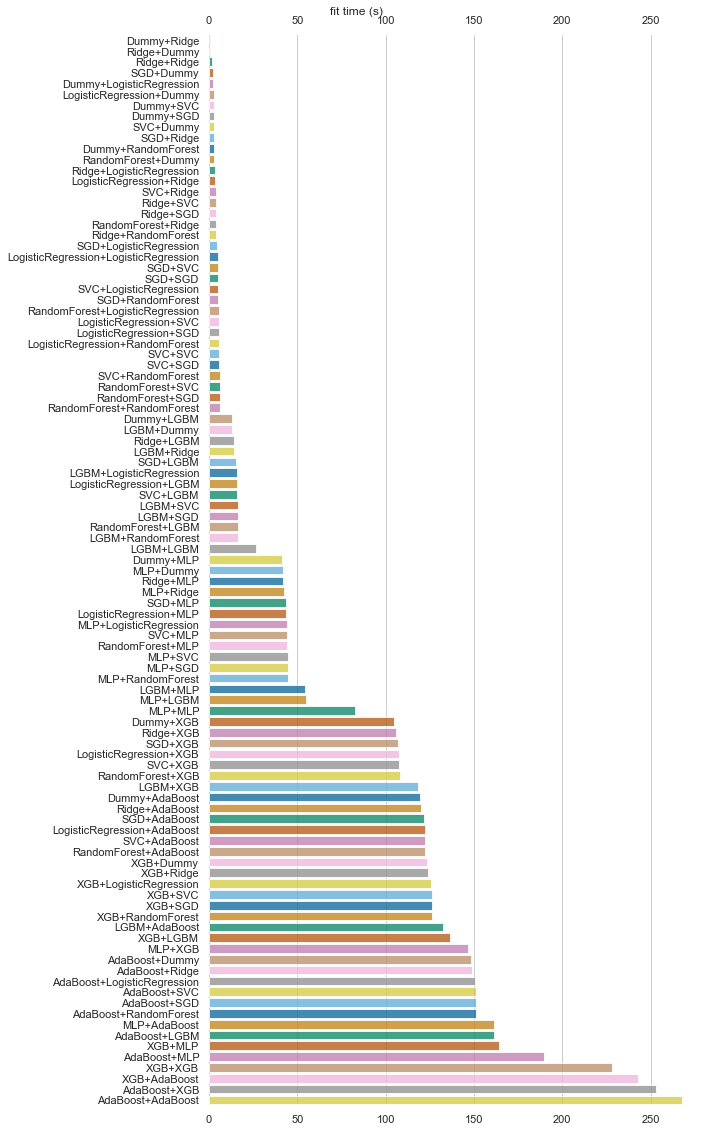

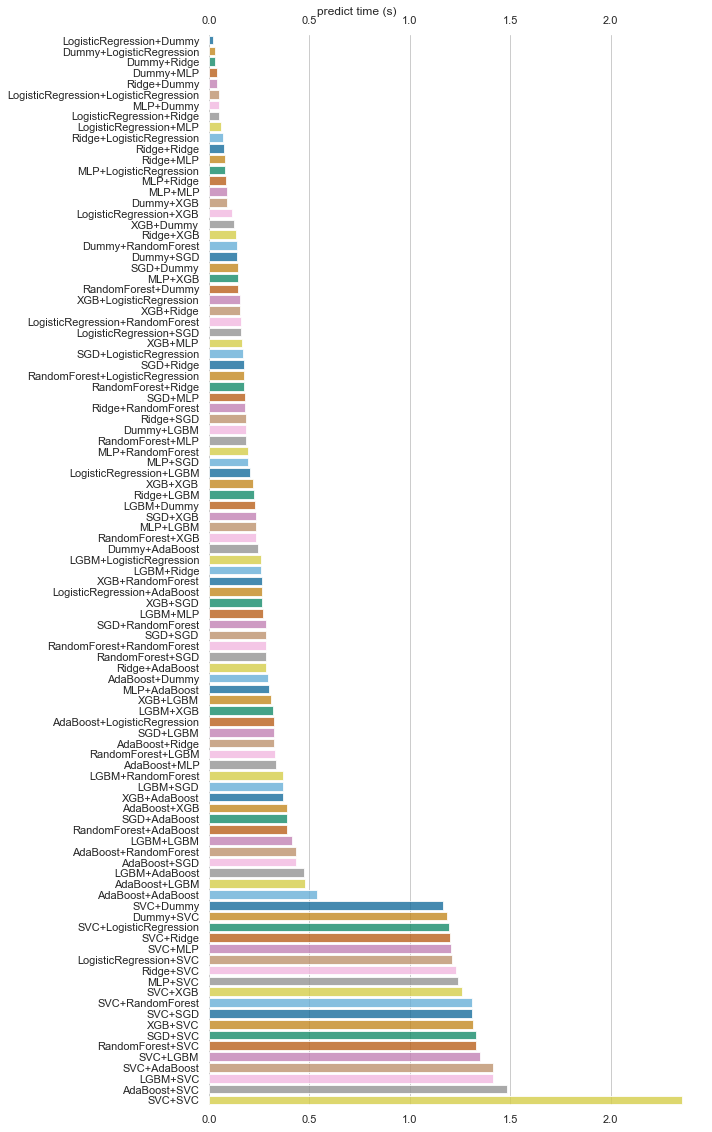

time: 10.6 s


In [24]:
for metric in tqdm(METRICS):
    plot_ternary_metric(metric, ternary_results_df)

## Classifier prediction correlation

In this section, we assess the correlation between each model's predictions. Performant and uncorrelated models are ideal for a potential stacked classifier.

For each case, pairwise Pearson correlations are calculated between model predictions and the absolute values of the correlation coefficients averaged over the folds. This is not a statistically pure approach since better methods for assessing categorical correlations (e.g., Cramer's V or Theil's U) exist and the Fisher's Z transformation was omitted, but it should be good enough; we just need to assess co-occurence to see which are most unassociated.

In [25]:
prediction_correlations = {}

for case in ALL_CASES:
    case_df = predictions_df.query(f"case == '{case}'")
    fold_correlations = []
    for fold in range(n_splits):
        df = case_df.query(f"fold == {fold}")
        df = (
            pd.DataFrame(
                {
                    # deleting Classifier makes for less cluttered visualization
                    model.replace("Classifier", ""): df.loc[
                        df.model == model, "y_pred"
                    ].item()
                    for model in np.unique(df.model)
                }
            )
            .corr()
            .swifter.apply(abs)
        )
        fold_correlations.append(df)
        del df
        _ = gc_collect()
    prediction_correlations[case] = (
        (_ := pd.concat(fold_correlations)).groupby(_.index).mean()
    )
    del case_df
    del fold_correlations
    _ = gc_collect()

Pandas Apply: 100%|██████████| 10/10 [00:00<?, ?it/s]


time: 2.54 s


In [26]:
def plot_prediction_correlations(case: str, drop_dummy: bool = True) -> None:
    """Plot heatmap for prediction correlations."""
    plt.figure(figsize=(12, 12))
    df = (
        prediction_correlations[case]
        .dropna(axis="columns", how="all")
        .dropna(axis="index", how="all")
        # classifiers whose predictions do not vary (e.g., dummy) produce NaN correlations and are dropped from visualization
    )
    if drop_dummy:
        df = df.loc[~df.index.isin(df.filter(like="Dummy", axis="index").index)]
        df.drop(columns=df.filter(like="Dummy", axis="columns").columns, inplace=True)
    g = sns.heatmap(
        data=df,
        vmin=0,
        vmax=1,
        cmap="coolwarm",
        square=True,
        mask=np.triu(np.ones_like(df, dtype=bool)),
    )
    plt.suptitle(f"{case} prediction correlations")
    plt.yticks(rotation=0)
    plt.show()
    del df
    del g
    _ = gc_collect()


_ = gc_collect()

time: 121 ms


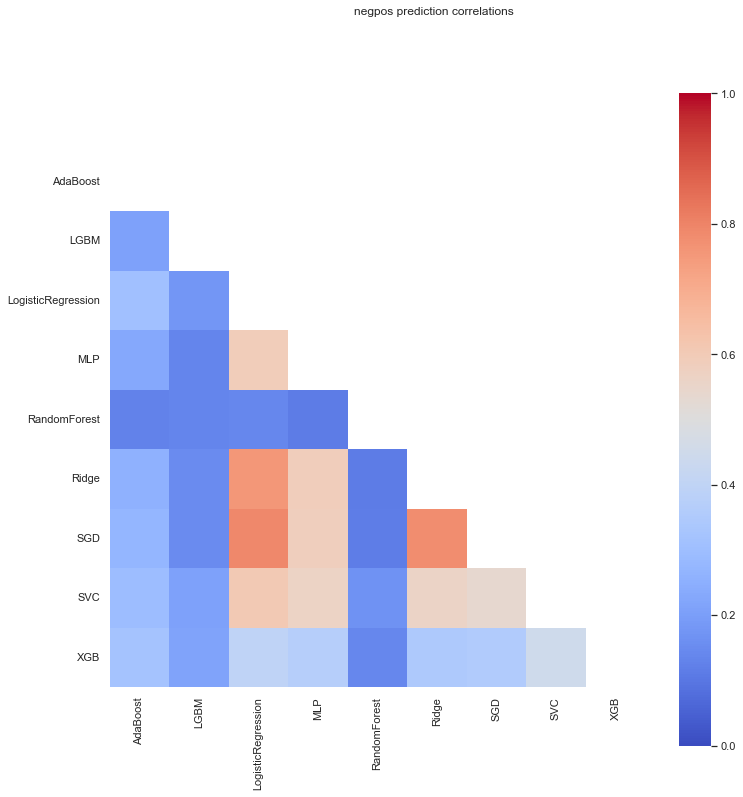

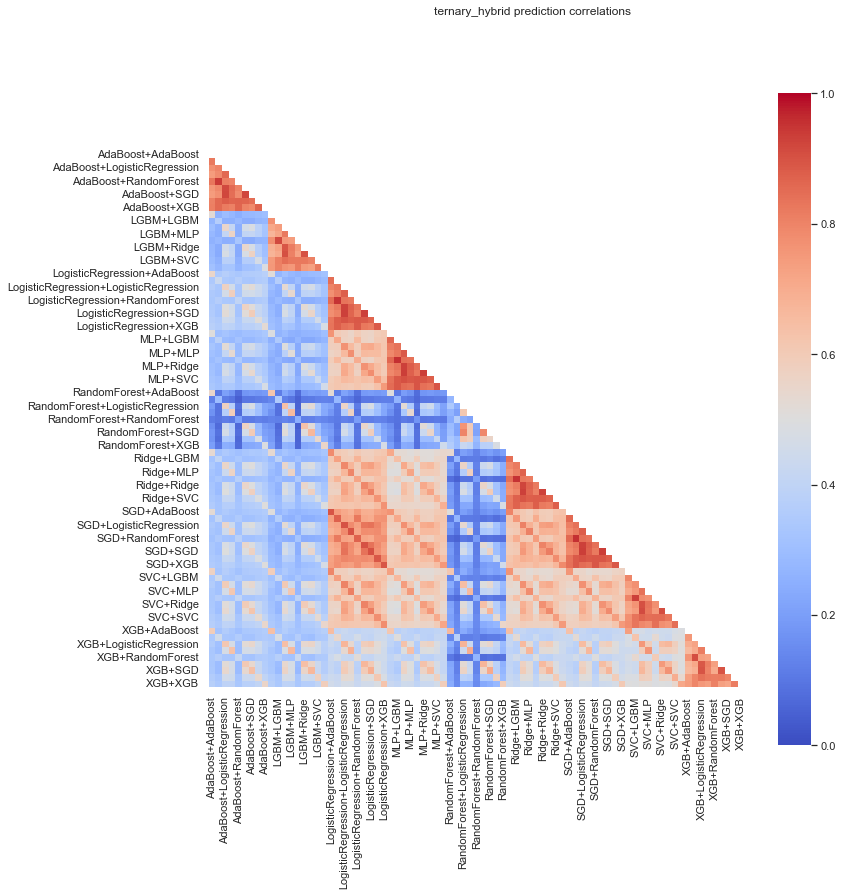

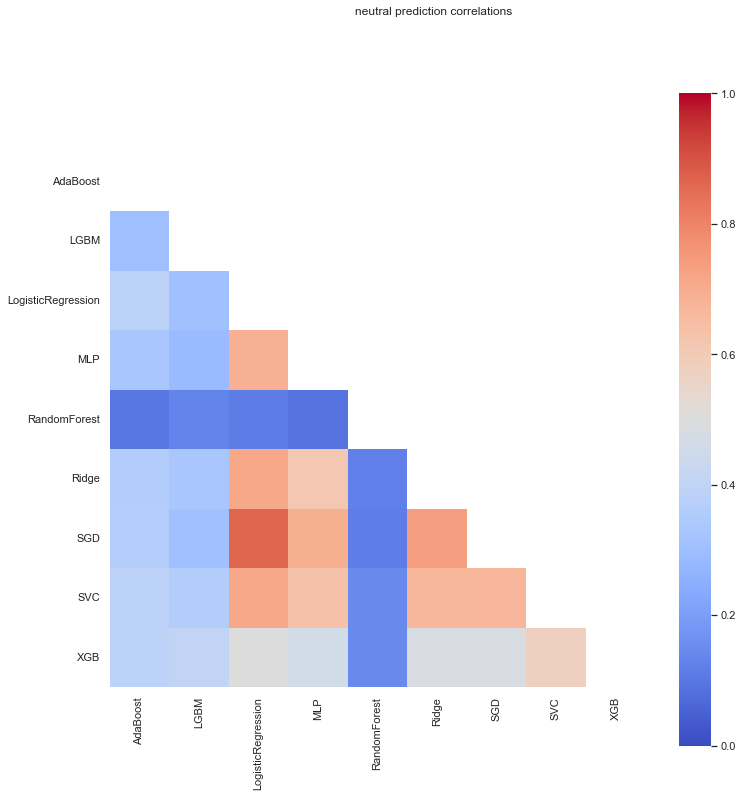

time: 2.21 s


In [27]:
for case in ALL_CASES:
    plot_prediction_correlations(case)

In [28]:
# save table of results
pd.concat((results_df, ternary_results_df)).to_csv(
    f"{DATA_OUT_FOLDER}/explore_hybrid_multiclass_results.csv"
)

time: 12 ms


# Discussion

These scores are middling, but almost all estimators outperformed the dummies.

The vanilla MLP from sklearn is one of the top contenders. This leaves open the possibility of pursuing a pure deep learning approach. I imagine a straightforward dense net with one or two hidden layers could be tuned.

The heatmaps reveal some hotspots of higher correlations. In the binary cases, these generally reflect the most performant classifiers. Although the tree-based methods aren't as performant as the others, they are the most uncorrelated, whereas the most performant models also have the most correlated predictions. In the hybrid ternary case, metaclassifiers that share sub-estimators are unsurprisingly the most correlated in prediction (illustrated by the mini-diagonals) and the same patterns may generally be observed.

Maybe an ensemble of just the tree-based methods (meta-ensemble?) would be appropriate and this assembly could be subsequently ensembled with the more performant classifiers.

In refactoring, I may consider extending the strata processing function to handle an arbitrary number of splits.

Class imbalance is lowest for the negative/non-negative binary classification task. For all other classification scenarios, class imbalance is notable. Re-sampling methods may be appropriate to boost performance.

---

At this point, we've considered OvO, OvR, and hybrid ternary classification as well as all the underlying cases. The MLP keeps showing up as a strong contender and thus warrants further investigation.

On the other hand, random forest has displayed only marginal skill relative to the dummy. If the tree-based classifiers are ensembled, the random forest models may be candidates for omission.

It was a little disappointing to see that the hybrid approach did not outperform the OvO and OvR classification scenarios, but the gap in performance is marginal and may disappear with tuning. Nevertheless, the hybrid approach is still appealing because it requires one less subestimator than the other ternary approaches and 1-2 predictions per inference as opposed to 3.

In [29]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 2015.5514180660248 s
time: 120 ms


[^top](#Contents)